# RAPIDS & Scanpy Single-Cell RNA Workflow

This notebook demonstrates an end-to-end single-cell RNA workflow that begins with preprocessing a `(n_gene, n_cell)` count matrix and results in a visualization of the clustered cells for further analysis. 

In [1]:
# Import requirements
import numpy as np
import scanpy as sc
import sys
import os

import cupy as cp

In [2]:
# Please note the csv file in in_file has been modified with the addition of `gene_name` to the very beginning of the csv index.
in_file = "counts_output.parquet"
out_dir = "."

In [3]:
import cudf
import anndata

import time
start = time.time()

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cudf/utils/cudautils.py:7: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.numpy_support', please update to use 'numba.np.numpy_support' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba import cuda, numpy_support
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cudf/core/column/categorical.py:12: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.numpy_support', please update to use 'numba.np.numpy_support' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from cudf._lib.transform import bools_to_mask
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cudf/utils/applyutils.py:7: NumbaDeprecationWarning: An import was requested from a module that h

## Preprocessing Stage 1
### (load counts -> filter -> normalize)

In [4]:
%%time
# Load data
df = cudf.read_parquet(in_file)

CPU times: user 898 ms, sys: 571 ms, total: 1.47 s
Wall time: 2.63 s


In [5]:
df.columns

Index(['cell', 'gene', 'molecule'], dtype='object')

In [6]:
genes = df['gene'].unique()

In [7]:
genes.shape

(32199,)

In [8]:
df.shape

(12136925, 3)

In [9]:
df["cell_id"] = df["cell"].astype('category').cat.codes
df["gene_id"] = df["gene"].astype('category').cat.codes

n_cells = df.cell_id.max()+1
n_genes = df.gene_id.max()+1

In [10]:
%%time
mito_genes = df[df["gene"].str.startswith("MT-")]["gene_id"].unique()

CPU times: user 6.16 ms, sys: 1.91 ms, total: 8.07 ms
Wall time: 7.39 ms


In [11]:
mito_genes

0     20790
1     20791
2     20792
3     20793
4     20794
5     20795
6     20796
7     20797
8     20798
9     20799
10    20800
11    20801
12    20802
13    20803
14    20804
15    20805
16    20806
17    20807
18    20808
19    20809
20    20810
21    20811
22    20812
23    20813
24    20814
25    20815
26    20816
27    20817
28    20818
29    20819
30    20820
31    20821
32    20822
33    20823
Name: gene_id, dtype: int32

In [12]:
%%time

# Convert to sparse cupy array
df.molecule = df.molecule.astype('float32')

# cellxgene
rows = cp.array(df.cell_id.to_gpu_array())
cols = cp.array(df.gene_id.to_gpu_array())
vals = cp.array(df.molecule.to_gpu_array())

gpu_array = cp.sparse.coo_matrix((vals, (rows, cols)), shape=(n_cells, n_genes))

CPU times: user 44.8 ms, sys: 36.5 ms, total: 81.4 ms
Wall time: 83.7 ms


In [13]:
gpu_array.shape

(5019, 32199)

In [14]:
%%time
# Move count matrix to sparse form to ease computational burden.
# Transpose to `(n_cells, n_genes)` in sparse form since it has less computational demands
sparse_gpu_array = gpu_array.tocsr()

CPU times: user 384 ms, sys: 208 ms, total: 592 ms
Wall time: 950 ms


In [15]:
sparse_gpu_array.shape

(5019, 32199)

In [16]:
del df

In [17]:
%%time
# Filter cells w/ 200 <= n_genes <= 6000
# Copying to host (scipy.sparse.csr_matrix) just for filtering. 
# Ref: https://github.com/cupy/cupy/issues/2360
col_sums = sparse_gpu_array.sum(axis=1)
query = ((200 <= col_sums) & (col_sums <= 6000)).ravel()
filtered_cells = sparse_gpu_array.get()[query.get()]

CPU times: user 112 ms, sys: 185 ms, total: 297 ms
Wall time: 346 ms


In [18]:
filtered_cells

<1082x32199 sparse matrix of type '<class 'numpy.float32'>'
	with 1357321 stored elements in Compressed Sparse Row format>

In [19]:
%%time
## Filter cells with >15% MT reads
n_counts = filtered_cells.sum(axis=1)
percent_mito = (filtered_cells[:,mito_genes.to_array()].sum(axis=1) / n_counts).ravel()
filtered_cells = filtered_cells[np.asarray(percent_mito < 0.15).ravel(),:]

CPU times: user 8.16 ms, sys: 4.13 ms, total: 12.3 ms
Wall time: 11.4 ms


In [20]:
%%time
## Remove zero columns
# Copying dense onto GPU for normalization
thr = np.asarray(filtered_cells.sum(axis=0) > 0).ravel()
filtered_cells = filtered_cells[:,thr]
# filtered_cells = cp.array(filtered_cells.todense())

CPU times: user 5.07 ms, sys: 4.06 ms, total: 9.13 ms
Wall time: 7.98 ms


In [21]:
filtered_cells

<515x21000 sparse matrix of type '<class 'numpy.float32'>'
	with 846378 stored elements in Compressed Sparse Row format>

In [22]:
%%time
import scipy
## Normalize to sum to 1e4 and perform log norm
target_sum = 1e4
sums = np.array(target_sum / filtered_cells.sum(axis=1)).ravel()

normalized = filtered_cells.multiply(sums[:, np.newaxis]) # Done on host for now
normalized = cp.sparse.csr_matrix(normalized)

CPU times: user 15.9 ms, sys: 8.7 ms, total: 24.6 ms
Wall time: 62.6 ms


In [23]:
%%time
normalized = normalized.log1p()

CPU times: user 1 ms, sys: 2.22 ms, total: 3.23 ms
Wall time: 3.27 ms


In [24]:
normalized.shape

(515, 21000)

In [25]:
n_counts = filtered_cells.sum(axis=1)
percent_mito = (filtered_cells[:,mito_genes.to_array()].sum(axis=1) / n_counts).ravel()


## Preprocess Stage 2
### (regress -> scale -> PCA) 

In [26]:
%%time
import anndata
adata = anndata.AnnData(normalized.get())

CPU times: user 21.5 ms, sys: 614 µs, total: 22.1 ms
Wall time: 21.4 ms


In [27]:
%%time

min_disp = 0.5

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=min_disp)
n_genes = sum(adata.var.highly_variable)
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.21 s, sys: 58.2 ms, total: 1.27 s
Wall time: 1.29 s


In [28]:
adata.X.shape

(515, 4290)

In [29]:
# scanpy uses a Gaussian GLM w/ identity link, which is equivalent to Linear Regression w/  OLS.

In [30]:


n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

In [31]:
regressors = cp.ones((n_counts.shape[0]*3)).reshape((n_counts.shape[0], 3), order="F")

In [32]:
regressors[:, 1] = n_counts
regressors[:, 2] = percent_mito

In [33]:
df_regressors = cudf.DataFrame.from_gpu_matrix(regressors)

In [34]:
# For each gene, we want to subtract the predicted values from the original values to
# regress out effects of total counts per cell and the percentage expressed of mitochondrial genes 

In [35]:
from cuml.linear_model import LinearRegression

# NOTE: The tens of thousands of little regressions required in this step 
# pose a singificant bottleneck to this workflow.

def _regress_out_chunk(data_chunk, regressors):
    """
    Performs a data_cunk.shape[1] number of local linear regressions,
    replacing the data in the original chunk w/ the regressed result. 
    """
    
    output = []
    
    for col in range(data_chunk.shape[1]):
        y = data_chunk[:,col]
        X = regressors
        lr = LinearRegression(fit_intercept=False)
        lr.fit(X, y, convert_dtype=True)
        mu = lr.predict(X)
        
        data_chunk[:, col] = y - mu

    return data_chunk

In [36]:
%%time
normalized = cp.array(adata.X.todense(), order="F")

CPU times: user 182 ms, sys: 112 ms, total: 294 ms
Wall time: 422 ms


In [37]:
normalized.shape

(515, 4290)

In [38]:
%%time
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

import dask.array as da

cluster = LocalCUDACluster()
client = Client(cluster)

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40084 instead
  http_address["port"], self.http_server.port
bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


CPU times: user 544 ms, sys: 265 ms, total: 809 ms
Wall time: 2.74 s


In [39]:
client

Client Scheduler: tcp://127.0.0.1:35921 Dashboard: http://127.0.0.1:40084/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


In [40]:
%%time
da_normalized = da.from_array(normalized, chunks=(-1, 1000), asarray=False)
da_normalized = da_normalized.map_blocks(lambda cols: _regress_out_chunk(cols, df_regressors), 
                                         dtype=cp.float32)

CPU times: user 5.42 ms, sys: 2.25 ms, total: 7.68 ms
Wall time: 9.6 ms


In [41]:
%%time
normalized = da_normalized.compute()

CPU times: user 1.03 s, sys: 296 ms, total: 1.33 s
Wall time: 32.8 s


In [42]:
normalized.shape

(515, 4290)

In [43]:
client.close()
cluster.close()

In [44]:
normalized.shape

(515, 4290)

In [45]:
%%time
# Scale to unit variance and clip values w/ std_dev > 10
mean = normalized.mean(axis=0)
stddev = cp.sqrt(normalized.var(axis=0))
normalized -= mean
normalized /= stddev

CPU times: user 6.6 ms, sys: 1.89 ms, total: 8.48 ms
Wall time: 16.9 ms


In [46]:
%%time
normalized[normalized>10] = 10

CPU times: user 9.27 ms, sys: 1.42 ms, total: 10.7 ms
Wall time: 34.8 ms


In [47]:
preprocess_time = time.time()

In [48]:
print("Total Preprocess time (includes data load): %s" % (preprocess_time-start))

Total Preprocess time (includes data load): 45.0316104888916


## Cluster & Visualize
### (pca -> cluster -> visualize)

In [49]:
cluster_start = time.time()

In [50]:
%%time
from cuml.decomposition import PCA
normalized = PCA(n_components=50).fit_transform(normalized)

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


CPU times: user 752 ms, sys: 278 ms, total: 1.03 s
Wall time: 1.48 s


In [51]:
%%time
import anndata
adata = anndata.AnnData(normalized.get())

CPU times: user 266 µs, sys: 3.16 ms, total: 3.42 ms
Wall time: 6.79 ms


In [52]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_pcs=50, method='rapids')

CPU times: user 3.5 s, sys: 2.02 s, total: 5.53 s
Wall time: 3.37 s


In [53]:
%%time
# UMAP
sc.tl.umap(adata, method='rapids')

AscontiguousArrayTime: 1.52587890625e-05
UMAP TIME: 1.2219414710998535
CPU times: user 349 ms, sys: 363 ms, total: 711 ms
Wall time: 1.24 s


In [54]:
%%time
# Louvain clustering
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 157 ms, sys: 63.4 ms, total: 220 ms
Wall time: 416 ms


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cugraph/structure/graph.py:334: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


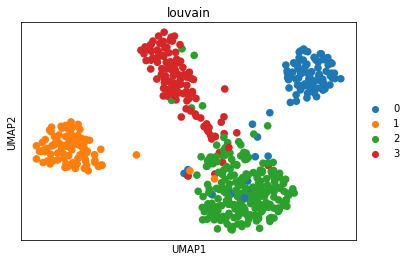

CPU times: user 135 ms, sys: 140 ms, total: 276 ms
Wall time: 119 ms


In [55]:
%%time
# Plot
sc.pl.umap(adata, color='louvain')

In [56]:
print("Cluster time: %s" % (time.time() - cluster_start))

Cluster time: 6.676515340805054


In [57]:
print("Full time: %s" % (time.time() - start))

Full time: 51.73027300834656
